![Approach](llm_repre.png)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Neural network model
class BostonNN(nn.Module):
    def __init__(self, in_dim):
        super(BostonNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)



def model_train(model, optimiser, x_train, y_train, x_test, y_test, n_epochs = 1000):    
    criterion = nn.MSELoss()
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        if (epoch+1) % 100 == 0:
    
            # Evaluation
            model.eval()
            with torch.no_grad():
                predictions = model(x_test)
                test_loss = criterion(predictions, y_test)
            
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f} Test Loss: {test_loss.item():.4f}")

    
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(x_test)
        test_loss = criterion(predictions, y_test)
        print(f"\n Final Test MSE Loss: {test_loss.item():.4f}")
            
    return predictions, loss.item(), test_loss.item()


In [3]:
def to_tensor(train_X, val_X, train_y, val_y):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train = scaler_X.fit_transform(train_X)
    X_test = scaler_X.transform(val_X)
    y_train = scaler_y.fit_transform(train_y)
    y_test = scaler_y.transform(val_y)
    
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor
    

In [4]:
def plot_prediction(y_pred, y_true):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', label="Predictions")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Prediction (y = x)')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Prediction vs True Value")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

In [5]:
def to_text(example):
    text = (
        f"This house is located in a town with a per capita crime rate of {example['CRIM']}, "
        f"{example['ZN']}% of residential land zoned for large lots, and {example['INDUS']}% non-retail business acreage. "
        f"It {'borders' if example['CHAS'] == '1' else 'does not border'} the Charles River. "
        f"The nitric oxide concentration is {example['NOX']}. The house has an average of {example['RM']} rooms, "
        f"with {example['AGE']}% of houses built before 1940. "
        f"It is {example['DIS']} units away from employment centers and has a RAD index of {example['RAD']}. "
        f"The property tax rate is ${example['TAX']} per $10,000, with a pupil-teacher ratio of {example['PTRATIO']}. "
        f"The B value is {example['B']}, and {example['LSTAT']}% of the population is of lower status."
    )
    return text

In [6]:
def set_seed(seed=42):
    random.seed(seed)                     # Python random module
    np.random.seed(seed)                  # NumPy
    torch.manual_seed(seed)               # CPU
    torch.cuda.manual_seed(seed)          # GPU
    torch.cuda.manual_seed_all(seed)      # All GPUs (if using DataParallel or DDP)
    
    # Ensure deterministic behavior (may slow down performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data
y = boston.target

In [8]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


In [9]:
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

In [10]:
for i in range(3):
    print('Sample {}'.format(i))
    print(X.iloc[i])
    print("TO")
    print(to_text(X.iloc[i]))
    print("############################################")

Sample 0
CRIM       0.00632
ZN            18.0
INDUS         2.31
CHAS             0
NOX          0.538
RM           6.575
AGE           65.2
DIS           4.09
RAD              1
TAX          296.0
PTRATIO       15.3
B            396.9
LSTAT         4.98
Name: 0, dtype: object
TO
This house is located in a town with a per capita crime rate of 0.00632, 18.0% of residential land zoned for large lots, and 2.31% non-retail business acreage. It does not border the Charles River. The nitric oxide concentration is 0.538. The house has an average of 6.575 rooms, with 65.2% of houses built before 1940. It is 4.09 units away from employment centers and has a RAD index of 1. The property tax rate is $296.0 per $10,000, with a pupil-teacher ratio of 15.3. The B value is 396.9, and 4.98% of the population is of lower status.
############################################
Sample 1
CRIM       0.02731
ZN             0.0
INDUS         7.07
CHAS             0
NOX          0.469
RM           6.421
AGE    

In [11]:
np.random.seed(34)
train_idx = np.random.choice(len(X), int(len(X)*0.8))
val_idx = np.setdiff1d(np.arange(len(X)), train_idx)

print('# of training set: {}'.format(len(train_idx)))
print('# of validation set: {}'.format(len(val_idx)))

# of training set: 404
# of validation set: 234


In [12]:

train_X = X.iloc[train_idx]
val_X = X.iloc[val_idx]
train_y = y.iloc[train_idx]
val_y = y.iloc[val_idx]

X_train, y_train, X_test, y_test = to_tensor(train_X.values, val_X.values, \
                                              train_y.values.reshape(-1,1), val_y.values.reshape(-1,1))

set_seed()
model = BostonNN(X_train.shape[1])
optimiser = optim.Adam(model.parameters(), lr=0.005)

print('Original Data, Feature numbers: {}'.format(X_train.shape[1]))

y_org_data_pred, loss_org_data, tloss_org_data = model_train(model, optimiser, X_train, y_train, X_test, y_test, n_epochs = 2000)

Original Data, Feature numbers: 13
Epoch [100/2000], Loss: 0.0485 Test Loss: 0.1813
Epoch [200/2000], Loss: 0.0143 Test Loss: 0.2211
Epoch [300/2000], Loss: 0.0061 Test Loss: 0.2495
Epoch [400/2000], Loss: 0.0036 Test Loss: 0.2697
Epoch [500/2000], Loss: 0.0019 Test Loss: 0.2810
Epoch [600/2000], Loss: 0.0015 Test Loss: 0.2894
Epoch [700/2000], Loss: 0.0010 Test Loss: 0.2920
Epoch [800/2000], Loss: 0.0008 Test Loss: 0.2934
Epoch [900/2000], Loss: 0.0008 Test Loss: 0.3023
Epoch [1000/2000], Loss: 0.0004 Test Loss: 0.3040
Epoch [1100/2000], Loss: 0.0003 Test Loss: 0.3049
Epoch [1200/2000], Loss: 0.0002 Test Loss: 0.3109
Epoch [1300/2000], Loss: 0.0002 Test Loss: 0.3135
Epoch [1400/2000], Loss: 0.0001 Test Loss: 0.3137
Epoch [1500/2000], Loss: 0.0005 Test Loss: 0.3168
Epoch [1600/2000], Loss: 0.0001 Test Loss: 0.3173
Epoch [1700/2000], Loss: 0.0001 Test Loss: 0.3192
Epoch [1800/2000], Loss: 0.0001 Test Loss: 0.3173
Epoch [1900/2000], Loss: 0.0002 Test Loss: 0.3195
Epoch [2000/2000], Loss:

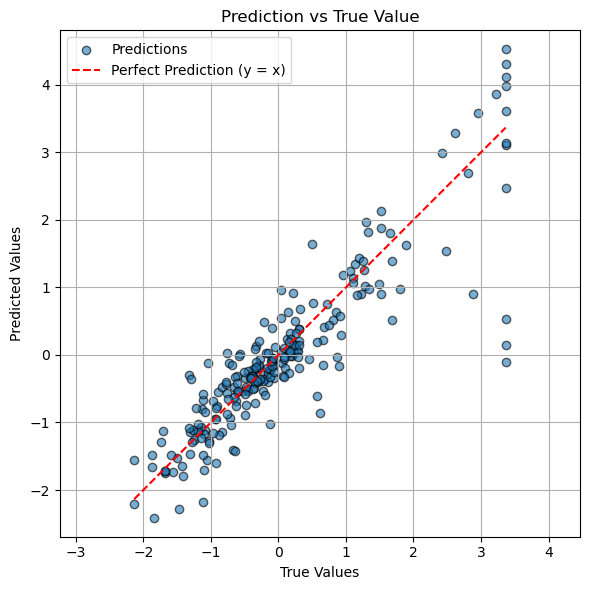

In [13]:
plot_prediction(y_org_data_pred, y_test)

In [14]:
load_name =  'llamat_7b.npz'
#Foundational Large Language Models for Materials Research
embeddings = np.load(load_name)
train_X_llamat = embeddings['train_embedding']
val_X_llamat = embeddings['val_embedding']

X_train, y_train, X_test, y_test = to_tensor(train_X_llamat, val_X_llamat, \
                                              train_y.values.reshape(-1,1), val_y.values.reshape(-1,1))

set_seed()
model = BostonNN(X_train.shape[1])
optimiser = optim.Adam(model.parameters(), lr=0.005)

print(train_X.shape)
print('Embedding Model: {}, Feature numbers: {}'.format(load_name.split('.')[0], X_train.shape[1]))

y_llamat_pred, loss_llamat_data, tloss_llamat_data = model_train(model, optimiser, X_train, y_train, X_test, y_test, n_epochs = 2000)

(404, 13)
Embedding Model: llamat_7b, Feature numbers: 4096
Epoch [100/2000], Loss: 0.0212 Test Loss: 0.5445
Epoch [200/2000], Loss: 0.0020 Test Loss: 0.4938
Epoch [300/2000], Loss: 0.0256 Test Loss: 0.5120
Epoch [400/2000], Loss: 0.0002 Test Loss: 0.4778
Epoch [500/2000], Loss: 0.0000 Test Loss: 0.4777
Epoch [600/2000], Loss: 0.0006 Test Loss: 0.4830
Epoch [700/2000], Loss: 0.0003 Test Loss: 0.4840
Epoch [800/2000], Loss: 0.0000 Test Loss: 0.4850
Epoch [900/2000], Loss: 0.0000 Test Loss: 0.4860
Epoch [1000/2000], Loss: 0.0046 Test Loss: 0.4991
Epoch [1100/2000], Loss: 0.0000 Test Loss: 0.5012
Epoch [1200/2000], Loss: 0.0000 Test Loss: 0.5012
Epoch [1300/2000], Loss: 0.0218 Test Loss: 0.5175
Epoch [1400/2000], Loss: 0.0001 Test Loss: 0.5142
Epoch [1500/2000], Loss: 0.0000 Test Loss: 0.5141
Epoch [1600/2000], Loss: 0.0000 Test Loss: 0.5140
Epoch [1700/2000], Loss: 0.0000 Test Loss: 0.5140
Epoch [1800/2000], Loss: 0.0000 Test Loss: 0.5140
Epoch [1900/2000], Loss: 0.0000 Test Loss: 0.5140

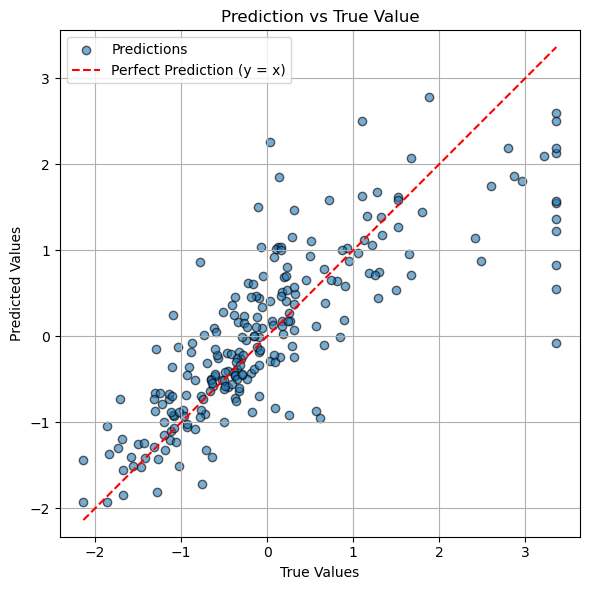

In [15]:
plot_prediction(y_llamat_pred, y_test)

In [16]:
load_name =  'llama2_7b.npz'
embeddings = np.load(load_name)
train_X_llama2 = embeddings['train_embedding']
val_X_llama2 = embeddings['val_embedding']

X_train, y_train, X_test, y_test = to_tensor(train_X_llama2, val_X_llama2, \
                                              train_y.values.reshape(-1,1), val_y.values.reshape(-1,1))

set_seed()
model = BostonNN(X_train.shape[1])
optimiser = optim.Adam(model.parameters(), lr=0.005)

print('Embedding Model: {}, Feature numbers: {}'.format(load_name.split('.')[0], X_train.shape[1]))

y_llama2_pred, loss_llama2_data, tloss_llama2_data = model_train(model, optimiser, X_train, y_train, X_test, y_test, n_epochs = 2000)

Embedding Model: llama2_7b, Feature numbers: 4096
Epoch [100/2000], Loss: 0.0525 Test Loss: 0.8534
Epoch [200/2000], Loss: 0.0000 Test Loss: 0.7994
Epoch [300/2000], Loss: 0.0000 Test Loss: 0.7876
Epoch [400/2000], Loss: 0.0001 Test Loss: 0.7738
Epoch [500/2000], Loss: 0.0000 Test Loss: 0.7743
Epoch [600/2000], Loss: 0.0000 Test Loss: 0.7743
Epoch [700/2000], Loss: 0.0001 Test Loss: 0.6702
Epoch [800/2000], Loss: 0.0000 Test Loss: 0.6697
Epoch [900/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [1000/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [1100/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [1200/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [1300/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [1400/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [1500/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [1600/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [1700/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [1800/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [1900/2000], Loss: 0.0000 Test Loss: 0.6696
Epoch [20

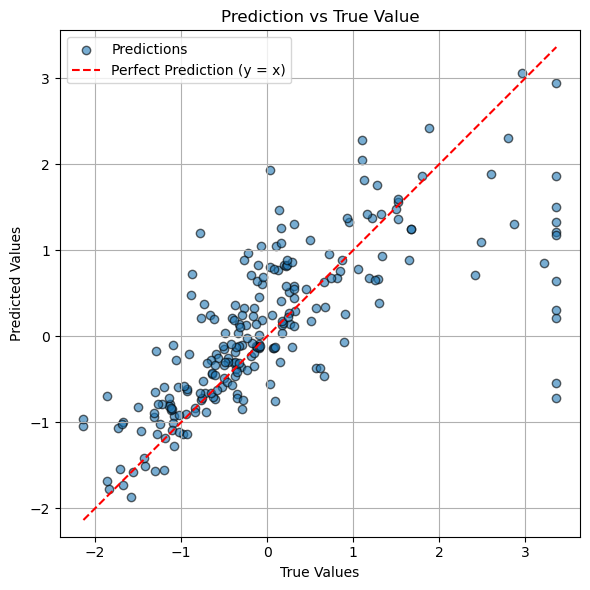

In [17]:
plot_prediction(y_llama2_pred, y_test)

In [18]:
load_name =  'llama_3_8b.npz'
embeddings = np.load(load_name)
train_X_llama3 = embeddings['train_embedding']
val_X_llama3 = embeddings['val_embedding']

X_train, y_train, X_test, y_test = to_tensor(train_X_llama3, val_X_llama3, \
                                              train_y.values.reshape(-1,1), val_y.values.reshape(-1,1))

set_seed()
model = BostonNN(X_train.shape[1])
optimiser = optim.Adam(model.parameters(), lr=0.005)

print('Embedding Model: {}, Feature numbers: {}'.format(load_name.split('.')[0], X_train.shape[1]))

y_llama3_pred, loss_llama3_data, tloss_llama3_data = model_train(model, optimiser, X_train, y_train, X_test, y_test, n_epochs = 2000)

Embedding Model: llama_3_8b, Feature numbers: 4096
Epoch [100/2000], Loss: 0.0094 Test Loss: 0.6843
Epoch [200/2000], Loss: 0.0347 Test Loss: 0.7692
Epoch [300/2000], Loss: 0.0000 Test Loss: 0.6291
Epoch [400/2000], Loss: 0.0000 Test Loss: 0.6287
Epoch [500/2000], Loss: 0.0079 Test Loss: 0.6410
Epoch [600/2000], Loss: 0.0094 Test Loss: 0.6299
Epoch [700/2000], Loss: 0.0202 Test Loss: 0.6307
Epoch [800/2000], Loss: 0.0000 Test Loss: 0.5741
Epoch [900/2000], Loss: 0.0000 Test Loss: 0.5786
Epoch [1000/2000], Loss: 0.0000 Test Loss: 0.5789
Epoch [1100/2000], Loss: 0.0000 Test Loss: 0.5789
Epoch [1200/2000], Loss: 0.0045 Test Loss: 0.6047
Epoch [1300/2000], Loss: 0.0000 Test Loss: 0.5819
Epoch [1400/2000], Loss: 0.0002 Test Loss: 0.5505
Epoch [1500/2000], Loss: 0.0000 Test Loss: 0.5544
Epoch [1600/2000], Loss: 0.0000 Test Loss: 0.5544
Epoch [1700/2000], Loss: 0.0000 Test Loss: 0.5544
Epoch [1800/2000], Loss: 0.0000 Test Loss: 0.5544
Epoch [1900/2000], Loss: 0.0000 Test Loss: 0.5544
Epoch [2

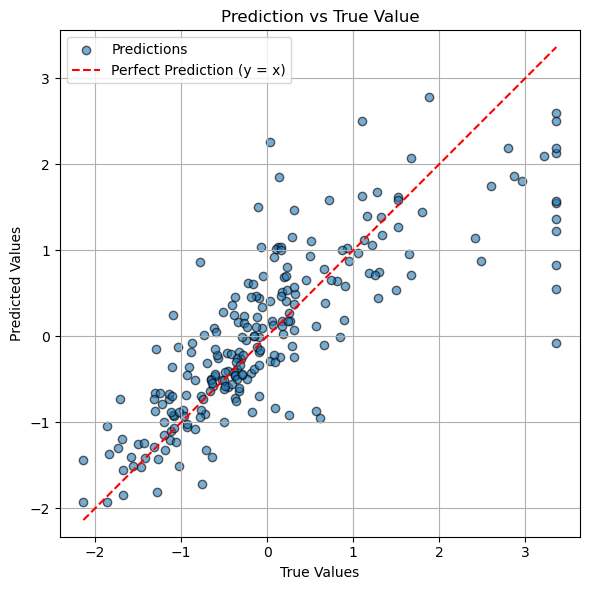

In [19]:
plot_prediction(y_llamat_pred, y_test)

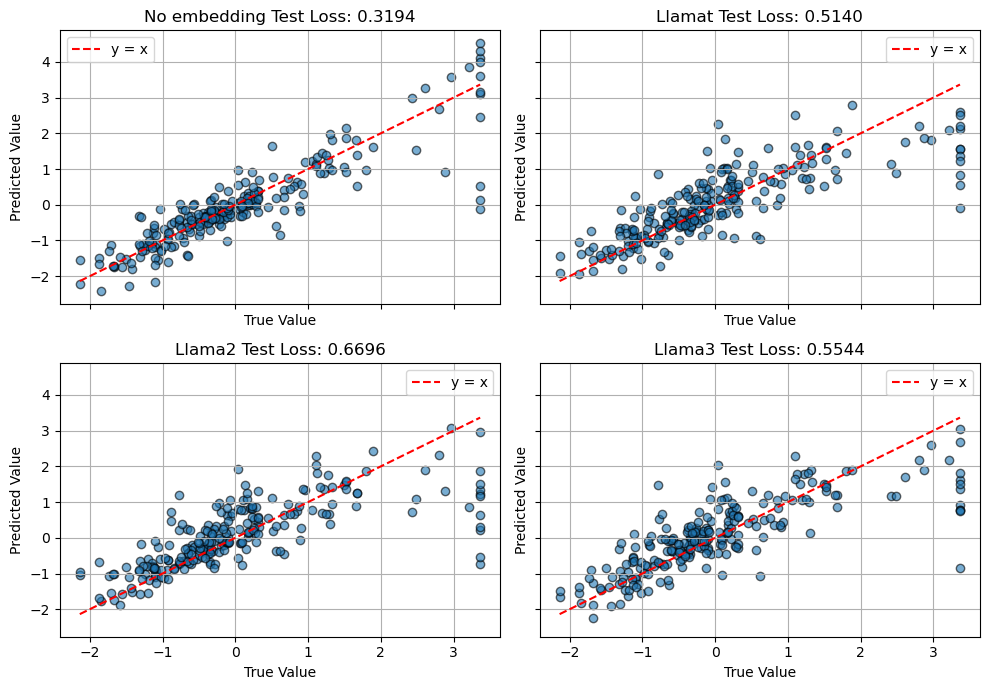

In [20]:
Ebedding_method = ["No embedding", "Llamat", "Llama2", "Llama3"]
y_preds = [y_org_data_pred, y_llamat_pred, y_llama2_pred, y_llama3_pred]
test_losses = [tloss_org_data, tloss_llamat_data, tloss_llama2_data, tloss_llama3_data]
titles = [f"{name} Test Loss: {loss:.4f}" for name, loss in zip(Ebedding_method, test_losses)]

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    ax.scatter(y_test, y_preds[i], alpha=0.6, edgecolors='k')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y = x')
    ax.set_title(titles[i])
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    ax.legend()
    ax.grid(True)
    #ax.set_aspect('equal')

#plt.suptitle("Prediction vs True Value (All Models)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd



train_losses = [loss_org_data, loss_llamat_data, loss_llama2_data, loss_llama3_data]  # Replace with your values
test_losses = [tloss_org_data, tloss_llamat_data, tloss_llama2_data, tloss_llama3_data]
n_features = [13, 4096, 4096, 4096]

loss_df = pd.DataFrame({
    "Embedding": Ebedding_method,
    "Train Loss": train_losses,
    "Test Loss": test_losses,
    "# of features": n_features
})

# Sort by Test Loss
loss_df = loss_df.sort_values(by="Test Loss").reset_index(drop=True)

loss_df

,Embedding,Train Loss,Test Loss,# of features
0,No embedding,5.908126e-05,0.319352,13
1,Llamat,3.937942e-09,0.514048,4096
2,Llama3,6.852244e-14,0.554384,4096
3,Llama2,7.309923e-14,0.669624,4096


In [22]:
def cov_mat(A, B):
    A_centered = A - A.mean(axis=0)
    B_centered = B - B.mean(axis=0)
    
    # Covariance
    cov = A_centered.T @ B_centered / (A.shape[0] - 1)
    
    # Standard deviations
    std_A = A_centered.std(axis=0, ddof=1)
    std_B = B_centered.std(axis=0, ddof=1)
    
    # Outer product to divide cov by standard deviations
    corr = cov / np.outer(std_A, std_B)  # Shape: (13, 4096)
    return corr

In [23]:
def get_cov(data):
    covmat = cov_mat(features, data)
    idxs = []
    for i in range(features.shape[1]):
        idx = np.argmax(np.abs(covmat[i, :]))
        idxs.append(idx)
    return covmat[:, idxs], covmat, idxs

def show_cov(covmat, idx):
    plt.figure(figsize=(8, 6))
    plt.imshow(np.abs(covmat), cmap='coolwarm', interpolation='none')
    plt.colorbar(label='Covariance')
    plt.title("Covariance Matrix")
    plt.xlabel("Embedding Features")
    plt.ylabel("Features")
    plt.xticks(ticks=np.arange(len(idx)), labels=idx, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(train_X.keys())), labels=train_X.keys())
    plt.tight_layout()
    plt.show()

In [24]:
features = train_X.values.astype(np.float32)

cov_key_, cov_, idxs_ = get_cov(features)
cov_llama2_key, cov_llama2, idxs_llama2 = get_cov(train_X_llama2)
cov_llama3_key, cov_llama3, idxs_llama3 = get_cov(train_X_llama3)
cov_llamat_key, cov_llamat, idxs_llamat = get_cov(train_X_llamat)

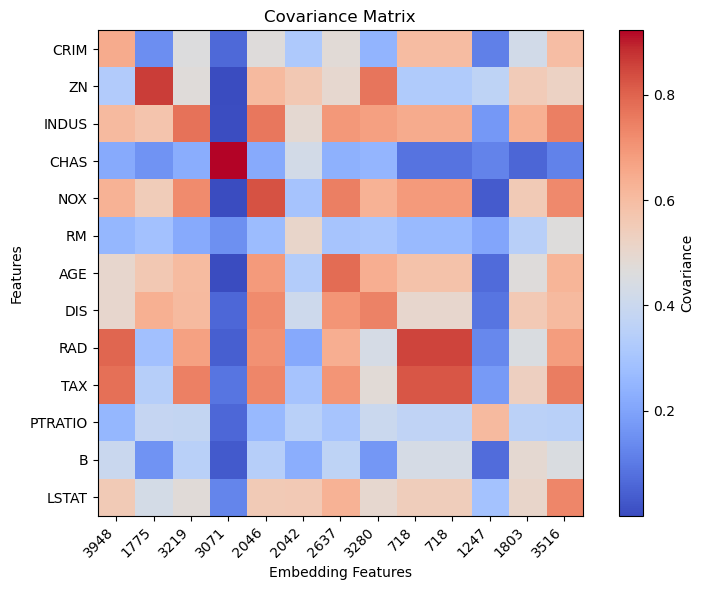

In [25]:
show_cov(cov_llama2_key, idxs_llama2)

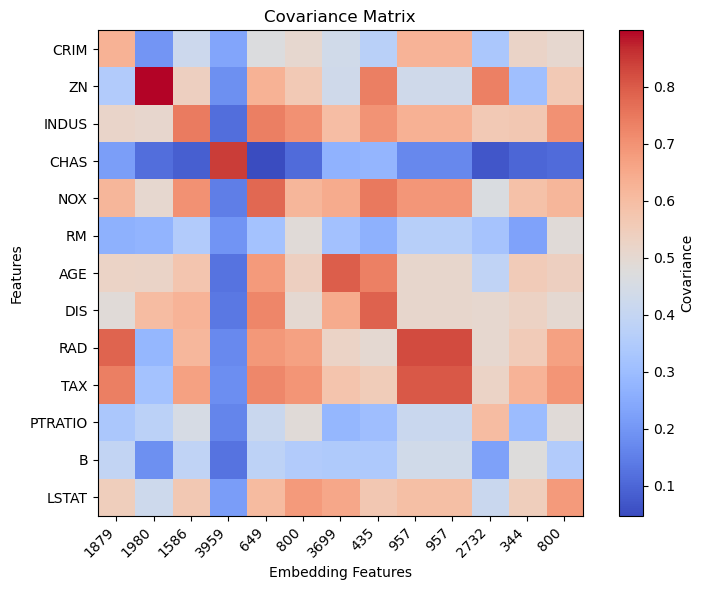

In [26]:
show_cov(cov_llama3_key, idxs_llama3)

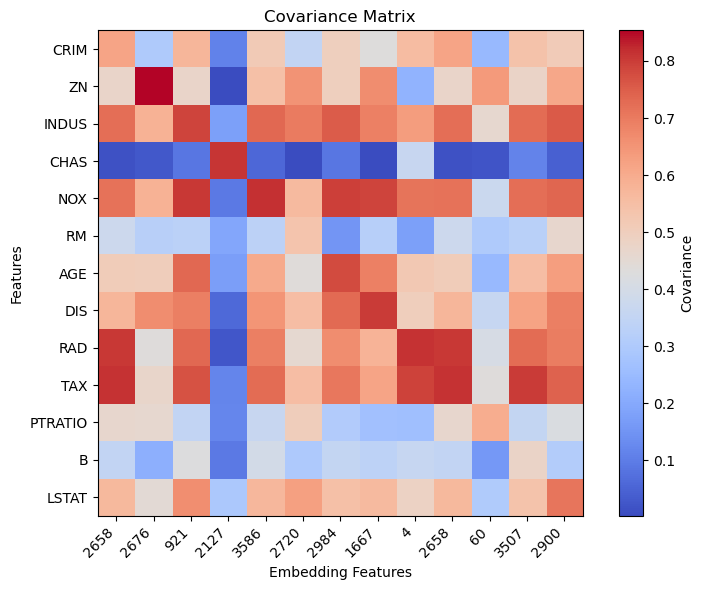

In [27]:
show_cov(cov_llamat_key, idxs_llamat)

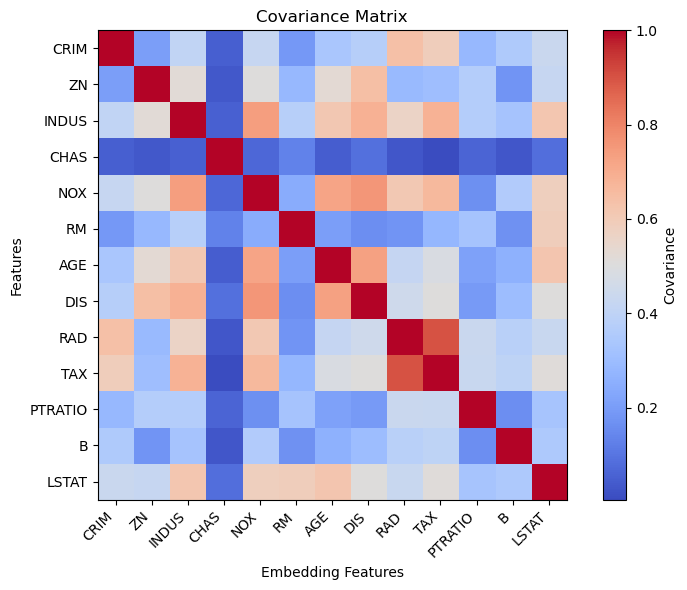

In [28]:
show_cov(cov_key_, train_X.keys())